# Preprocessing

In [1]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
import tensorflow as tf
import torch
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, Flatten
from keras.preprocessing.sequence import pad_sequences
import string
import re

D:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3



In [3]:
# #I added code to work on gpu if it is possible
# if torch.cuda.is_available():
#   device= 'cuda'
# else:
#   device='cpu'

In [4]:
# # Load your text data from the file
# paragraphs=[]
# with open('De_Pallio.txt', 'r') as file:
#     paragraphs = [[paragraph.strip()] for paragraph in file.readlines()]

# # Filter out empty paragraphs
# paragraphs = [paragraph[0] for paragraph in paragraphs if paragraph[0]]
# paragraphs = [[paragraph.strip()] for paragraph in paragraphs]

In [5]:
with open('Stopwords_latin.txt', 'r') as stop_words_file:
    stop_words = stop_words_file.read().splitlines()

In [6]:
# Load your text data from the file
paragraphs=[]
with open('Corpus.txt', 'r', encoding='utf-8') as file:
    paragraphs = [[paragraph.strip()] for paragraph in file.readlines()]

# Filter out empty paragraphs
paragraphs = [paragraph[0] for paragraph in paragraphs if paragraph[0]]
paragraphs = [[paragraph.strip()] for paragraph in paragraphs]

In [7]:
paragraphs[:3]

[['Magnum de modico malum scorpio terra suppurat. Tot uenena quot et genera, tot pernicies quot et species, tot dolores quot et colores. Nicander scribit et pingit. Et tamen unus omnium uiolentiae gestus de cauda, non ore; quae cauda erit, quodcumque de postumo corporis propagatur et uerberat. * * * perinde scorpii: series illa nodorum uenenata intrinsecus uenula subtilis arcuato impetu insurgens hamatile spiculum in summo tormenti ratione stringit. [2] Vnde et bellicam machinam retractu tela uegetantem de scorpio nominant. Id spiculum et fistula est patula tenuitate et uirus, qua figit, in uulnus effundit. Familiare periculi tempus aestas; Austro et Africo saeuitia uelificat. In remediis naturalia plurimum; aliquid et magia circumligat; medicina cum ferro et poculo occurrit. [3] Nam et praebibunt quidam festinando tutelam; sed concubitus exhaurit, et denuo sitiunt. Nobis fides praesidium, si non et ipsa percutitur diffidentia signandi statim et adiurandi et iniciendi bestiae calcem. [

In [8]:
data=[]
for i in range(len(paragraphs)):
    for j in range(len(paragraphs[i])):
        text = paragraphs[i][j].translate(str.maketrans('', '', string.punctuation))
        text = text.lower()

        # Suppression des nombres
        text = re.sub(r'\d+', '', text)

        # Tokenisation du texte
        words = text.split()
    
        #Suppresion des stop-words
        words = [word for word in words if word not in stop_words]
        # data.append(paragraphs[i][j].split())
        data.append(words)

In [9]:
paragraphs=data

In [ ]:
paragraphs

In [13]:
from keras.preprocessing.text import Tokenizer
# max_words = 1000  # Adjust this number based on your preference
# tokenizer = Tokenizer(num_words=max_words, oov_token="<unknown>")
# tokenizer.fit_on_texts(paragraphs)

min_word_frequency = 10  # Adjust this based on your preference
tokenizer = Tokenizer()
tokenizer.fit_on_texts(paragraphs)

# Filter out less frequent words
word_counts = tokenizer.word_counts
tokenizer.word_index = {word: index for word, index in tokenizer.word_index.items() if word_counts[word] >= min_word_frequency}
tokenizer.word_index[tokenizer.oov_token] = len(tokenizer.word_index) + 1  # Add "unknown" token
total_words = len(tokenizer.word_index) + 1

# Create sequences
sequences = tokenizer.texts_to_sequences(paragraphs)

# Pad sequences
padded_sequences = sequence.pad_sequences(
                  sequences, #Use our train dataset
                  maxlen=max(len(seq) for seq in sequences), #Max length
                  dtype='int32',
                  padding='post',  #Add zeros if needed to the max length
                  truncating='post', # Truncate sequence that are too long
                  value=0.0 # Value to add at the end of the sequence if it is too short
              )

In [12]:
max(len(seq) for seq in sequences)

255

In [13]:
padded_sequences[:10]

array([[ 257, 1848,   61, ...,    0,    0,    0],
       [ 216,  459,  617, ...,    0,    0,    0],
       [2220, 1686,    2, ...,    0,    0,    0],
       ...,
       [ 528,  509,    3, ...,    0,    0,    0],
       [ 438, 1873,  481, ...,    0,    0,    0],
       [ 124, 1692,   58, ...,  240, 2507,   38]])

In [14]:
# Generate random labels
labels = np.random.randint(2, size=(len(padded_sequences),))

In [15]:
labels

array([0, 0, 1, ..., 1, 0, 1])

In [16]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(padded_sequences, labels,test_size=0.33,random_state=46)

# Embedding

In [17]:
K.clear_session()
top_words = len(tokenizer.word_index) + 1
embedding_dim = 10

In [18]:
top_words

2769

In [20]:
# --- Using the Sequential API
model = Sequential()
model.add(Embedding(top_words,embedding_dim)) #To embed the inputs
model.add(LSTM(50,dropout=0.2,recurrent_dropout=0.2,return_sequences=True)) # Use a LSTM with dropout
model.add(LSTM(30,dropout=0.2,recurrent_dropout=0.2,return_sequences=True)) # Use a LSTM with dropout
model.add(LSTM(10,dropout=0.2,recurrent_dropout=0.2)) # Use a LSTM with dropout
model.add(Dense(1,activation="sigmoid")) #Perform a binary classification
print(f"Architecture of our model using the Sequential API")
print(model.summary())
# --- END CODE HERE

Architecture of our model using the Sequential API
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 10)          27690     
                                                                 
 lstm_2 (LSTM)               (None, None, 50)          12200     
                                                                 
 lstm_3 (LSTM)               (None, None, 30)          9720      
                                                                 
 lstm_4 (LSTM)               (None, 10)                1640      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 51261 (200.24 KB)
Trainable params: 51261 (200.24 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

In [21]:
# --- compile and fit the model
###### With the Sequential API
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_test, y_test))
#Save model
model.save('test.h5')
# model.fit(padded_sequences, labels, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/2
337/337 [==============================] - 184s 527ms/step - loss: 0.6933 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.4982
Epoch 2/2
337/337 [==============================] - 194s 577ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4982


D:\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [70]:
# from keras.models import load_model
# # Load the model
# model = load_model('your_model.h5')

In [71]:
# # --- Final evaluation of the model
# ###### With the Sequential API
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

In [22]:
# Get the word_index dictionary
word_index = tokenizer.word_index
# Get the word for a specific index
index_to_lookup = 25
word_at_index = next(word for word, index in word_index.items() if index == index_to_lookup)

print(f"The word at index {index_to_lookup} is: {word_at_index}")

The word at index 25 is: dominum


In [23]:
def extract_closest_word(word):
    # Get the word_index dictionary
    word_index = tokenizer.word_index
    # Get the index of a specific word
    word_to_lookup = word
    index_of_word = word_index.get(word_to_lookup, None)
    
    if index_of_word is not None:
        print(f"The index of '{word_to_lookup}' is: {index_of_word}")
    else:
        print(f"'{word_to_lookup}' not found in the vocabulary.")
        
    # Get the embedding matrix
    embedding_matrix = model.layers[0].get_weights()[0]

    print("Embedding Matrix Shape:" +str(embedding_matrix.shape) + "\n")
    
    # --- START CODE HERE (04)
    embedding_weights = embedding_matrix # Get the weights of the embedding layer
    index_great = index_of_word # Get the index of the word "great"
    word_embedding_great=embedding_weights[index_great,:] # Get the embedding of the word great
    # print(f"The embedding of the word {word_to_lookup} is :")
    # print(word_embedding_great)


    dist_v= tf.norm(embedding_weights - embedding_weights[index_great], axis=1) # euclidean norm by default


    for i in np.argsort(dist_v)[1:20]: print(str(next(word for word, index in word_index.items() if index == i)) 
                                               + " | Distance : " + str(dist_v[i].numpy()))

In [26]:
extract_closest_word("caro")

The index of 'caro' is: 15
Embedding Matrix Shape:(2769, 10)

stabit | Distance : 0.04753286
delictorum | Distance : 0.051853217
perditionis | Distance : 0.05218937
voluntate | Distance : 0.05506863
prophetes | Distance : 0.061316058
belli | Distance : 0.062474955
veritatis | Distance : 0.063147865
prophetarum | Distance : 0.06332726
spectaculum | Distance : 0.06347345
colitis | Distance : 0.065103896
praeiudicatum | Distance : 0.065265104
utpote | Distance : 0.06554925
tempori | Distance : 0.06593648
proprietatem | Distance : 0.06670224
extranei | Distance : 0.068008065
sortem | Distance : 0.071364954
ambitio | Distance : 0.07142244
incesti | Distance : 0.07170341
marcionem | Distance : 0.07290262


In [27]:
X_train[:10]

array([[2744,    0,    0, ...,    0,    0,    0],
       [ 842,    0,    0, ...,    0,    0,    0],
       [1139,    5,    0, ...,    0,    0,    0],
       ...,
       [   4,  252,  102, ...,    0,    0,    0],
       [ 168,    0,    0, ...,    0,    0,    0],
       [ 253,    1,    5, ...,    0,    0,    0]])

## Visualisation

In [28]:
next(word for word, index in word_index.items() if index == 1)

'dei'

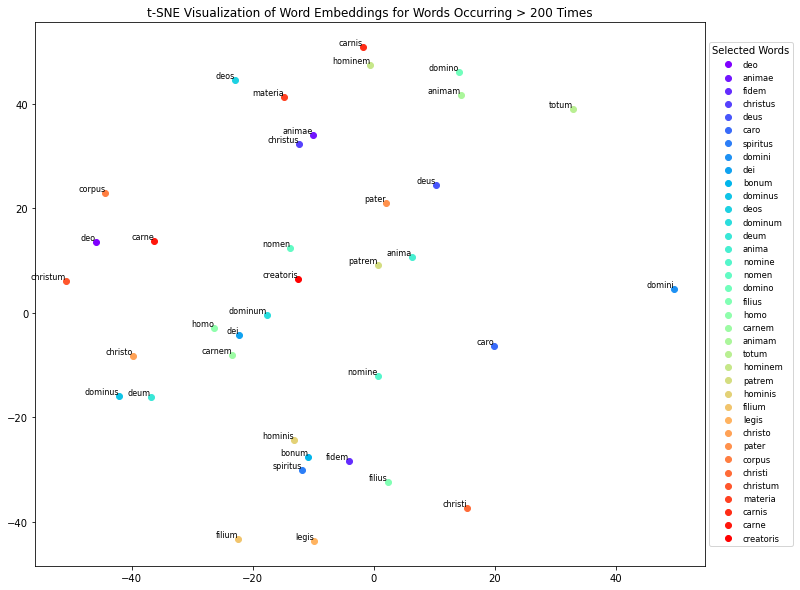

In [39]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.metrics import pairwise_distances

minimum = 200

# Assuming word_embeddings is your embedding matrix and labels is a list of corresponding labels
# Replace these with your actual data
word_embeddings = model.layers[0].get_weights()[0]  # Your word embeddings matrix
# Your list of labels

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
embedded_words = tsne.fit_transform(word_embeddings)

# Calculate pairwise distances between embedded words
distances = pairwise_distances(embedded_words)

# Plot the t-SNE visualization with labels for the top words
plt.figure(figsize=(12, 10))

# Get word frequencies and select words that occur more than 10 times
selected_words = [word for word, count in tokenizer.word_counts.items() if count > minimum]

# Define a colormap for the selected words based on distances
colors = plt.cm.rainbow(np.linspace(0, 1, len(selected_words)))

for i, word in enumerate(selected_words):
    index = tokenizer.word_index.get(word)
    if index is not None:
        x, y = embedded_words[index, :]
        color = colors[i]
        plt.scatter(x, y, label=word, color=color)
        plt.text(x, y, word, fontsize=8, ha='right', va='bottom', color='black')

plt.title(f't-SNE Visualization of Word Embeddings for Words Occurring > {minimum} Times')
plt.legend(title='Selected Words', loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.show()


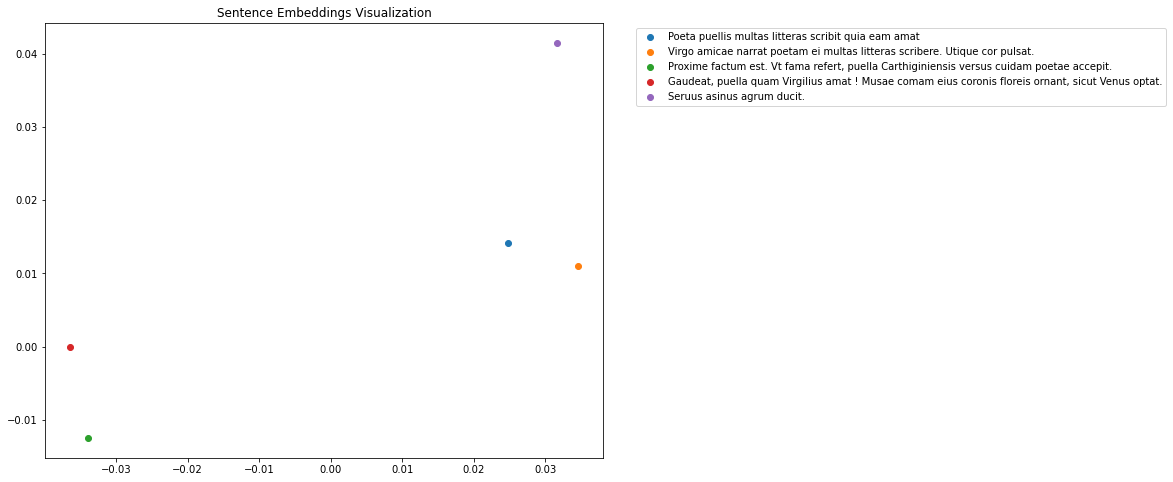

In [40]:
# Assuming you have a list of sentences
sentences = ["Poeta puellis multas litteras scribit quia eam amat",
            "Virgo amicae narrat poetam ei multas litteras scribere. Utique cor pulsat.",
            "Proxime factum est. Vt fama refert, puella Carthiginiensis versus cuidam poetae accepit.",
            "Gaudeat, puella quam Virgilius amat ! Musae comam eius coronis floreis ornant, sicut Venus optat.",
            "Seruus asinus agrum ducit."]  # Replace with your actual list of sentences


import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the model loaded and ready

# Tokenize and pad the sentences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

# Pad sequences to have consistent length
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Generate embeddings using the model
embeddings = model.layers[0].get_weights()[0]

# Function to calculate the Euclidean distance between two vectors
def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

# Function to visualize embeddings with legend on the right and outside the plot
def visualize_embeddings_with_legend(embeddings, sentences, title):
    plt.figure(figsize=(10, 8))
    for i, sentence in enumerate(sentences):
        plt.scatter(embeddings[i, 0], embeddings[i, 1], label=sentence)

    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Visualize embeddings with legend on the right and outside the plot
visualize_embeddings_with_legend(embeddings[:, :2], sentences, "Sentence Embeddings Visualization")

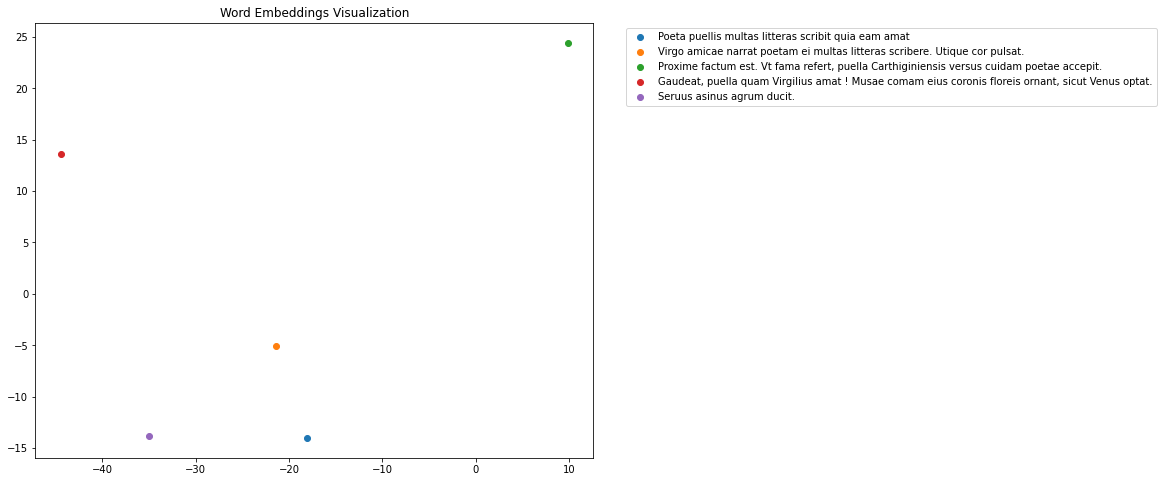

In [41]:
from sklearn.manifold import TSNE
embeddings_tsne = TSNE(n_components=2).fit_transform(embeddings)
visualize_embeddings_with_legend(embeddings_tsne, sentences, "Word Embeddings Visualization")

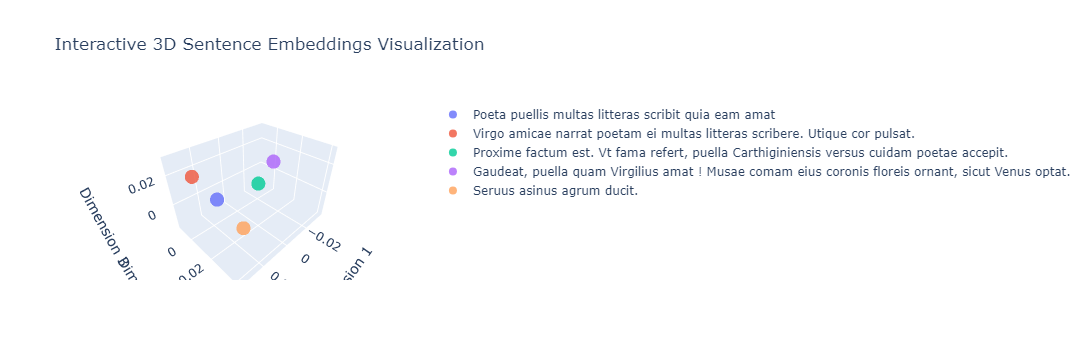

In [42]:
import plotly.graph_objects as go

# Assuming you have the model loaded and ready

# Tokenize and pad the sentences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

# Pad sequences to have consistent length
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Generate embeddings using the model
embeddings = model.layers[0].get_weights()[0]

# Create a 3D scatter plot with plotly
fig = go.Figure()

for i, sentence in enumerate(sentences):
    fig.add_trace(go.Scatter3d(
        x=[embeddings[i, 0]],
        y=[embeddings[i, 1]],
        z=[embeddings[i, 2]],
        text=[sentence],
        mode='markers',
        marker=dict(
            size=8,
            color=i,  # You can use a color scale if needed
            opacity=0.8
        ),
        name=sentence
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3',
    ),
    title='Interactive 3D Sentence Embeddings Visualization'
)

# Display the plot in the notebook
fig.show()

# Save the plot as an HTML file
fig.write_html("interactive_3d_plot.html")


1/1 [==============================] - 0s 402ms/step


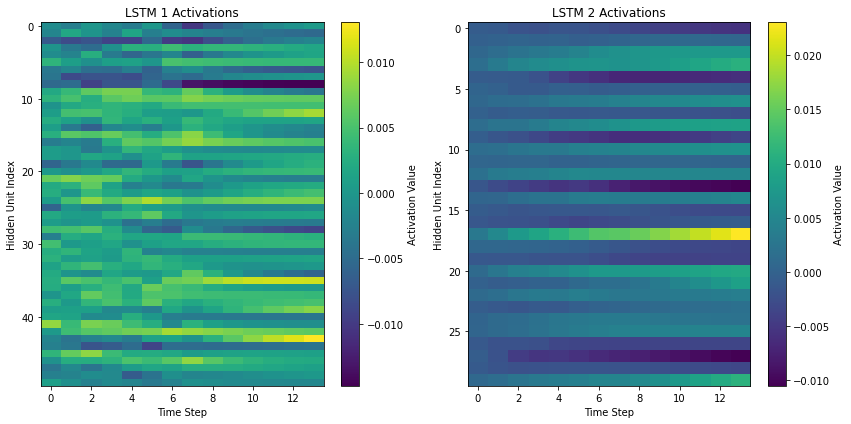

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a model with LSTM layers
# You may need to modify this based on your actual model architecture

# Tokenize and pad the sentences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

# Convert a specific sentence to sequences
input_sentence = "Poeta puellis multas litteras scribit quia eam amat"
input_sequence = tokenizer.texts_to_sequences([input_sentence])
input_padded = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')

# Get the activations of LSTM layers
activation_model = Model(inputs=model.input, outputs=[model.get_layer('lstm_2').output, model.get_layer('lstm_3').output])
lstm1_activations, lstm2_activations = activation_model.predict(input_padded)

# Plot the activations with a colorbar
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(lstm1_activations.T, interpolation='nearest', cmap='viridis', aspect='auto')
plt.title('LSTM 1 Activations')
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit Index')
plt.colorbar(label='Activation Value')

plt.subplot(1, 2, 2)
plt.imshow(lstm2_activations.T, interpolation='nearest', cmap='viridis', aspect='auto')
plt.title('LSTM 2 Activations')
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit Index')
plt.colorbar(label='Activation Value')

plt.tight_layout()
plt.show()


In [46]:
from sklearn.decomposition import NMF
import numpy as np

# Assuming 'word_embeddings' is your word embeddings matrix
# 'word_embeddings' should be a 2D array with dimensions (vocab_size, embedding_dim)

# Ensure all values are non-negative (replace negative values with zero)
word_embeddings_non_negative = np.maximum(word_embeddings, 0)

# Number of topics you want to extract
num_topics = 5

# Create and fit NMF model
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(word_embeddings_non_negative)

# Get the topic distributions for each word
word_topic_distributions = nmf.transform(word_embeddings_non_negative)

# Print the top words for each topic
feature_names = [str(i) for i in range(word_embeddings.shape[1])]
for topic_idx, topic in enumerate(nmf.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Get indices of top 10 words
    top_words=[]
    for id in top_words_idx:
        if not  id == 0:
            top_words.append(next(word for word, index in word_index.items() if index == id))
    print(f"Topic #{topic_idx + 1}:")
    print(top_words)

Topic #1:
['creatoris', 'deus', 'deum', 'christum', 'dominus', 'spiritus', 'christus', 'deo', 'dei']
Topic #2:
['christus', 'deum', 'christum', 'dominus', 'creatoris', 'spiritus', 'deo', 'deus', 'dei']
Topic #3:
['deo', 'deus', 'dominus', 'deum', 'christum', 'creatoris', 'spiritus', 'christus', 'dei']
Topic #4:
['dei', 'dominus', 'christum', 'deum', 'creatoris', 'spiritus', 'christus', 'deo', 'deus']
Topic #5:
['spiritus', 'christum', 'dominus', 'creatoris', 'christus', 'deum', 'deo', 'deus', 'dei']


D:\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

